# Predicting superconductor critical temperatures

# Regressions on the raw dataset

## Importing the required modules

In [27]:
from math import sqrt
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from prep import dedup, norm, reduce
from util import tsplit, read_train_test
from regr import linreg, knnreg, treereg, randreg, adareg, svmreg, votreg, xgbreg
from hypopt import knnhyp, treehyp, randhyp, adahyp, svmhyp, xgbhyp

## Registering the start time for runtime calculation

In [28]:
start = time.time()

## Set the parameters according to the hyperparameter optimization

In [64]:
# linear regression:
grd = 1

# kNN:
kmin = 4

# Decision Tree:
max_depth_tr = 41
min_samples_split_tr = 35

# Random Forest:
max_depth_rf = 165
min_samples_split_rf = 2

# Ada Boost:
learning_rate_ada = 1.0
n_estimators_ada = 14

# SVM:
c_svm = 250
kernel_svm = 'rbf'

# XGBoost:
learning_rate_xgb = 0.07
subsample_xgb = 1.0

## Read the training and test data from file

In [54]:
x_train, x_test, y_train, y_test = read_train_test('../data/sup_norm_tr.csv', '../data/sup_norm_te.csv')

## Linear regression

In [55]:
lin, lin_pred, rmse_lin = linreg(x_train, x_test, y_train, y_test, grd=grd)

Linear Regression -> RMSE = 17.7222


## kNN regression

In [65]:
knn, knn_pred, rmse_knn = knnreg(x_train, x_test, y_train, y_test, k=kmin)

kNN Regression -> RMSE = 10.2556


## Decision Tree regression

In [57]:
tr, tr_pred, rmse_tr = treereg(x_train, x_test, y_train, y_test, max_depth=max_depth_tr, min_samples_split=min_samples_split_tr)

Decision Tree Regression -> RMSE = 11.5910


## Random Forest regression

In [58]:
rf, rf_pred, rmse_rf = randreg(x_train, x_test, y_train, y_test, max_depth=max_depth_rf, min_samples_split=min_samples_split_rf)

Random Forest Regression -> RMSE = 9.4810


## Ada Boost regression

In [59]:
ada, ada_pred, rmse_ada = adareg(x_train, x_test, y_train, y_test, learning_rate=learning_rate_ada, n_estimators=n_estimators_ada)

Ada Boost Regression -> RMSE = 18.0978


## SVM regression

In [60]:
svm, svm_pred, rmse_svm = svmreg(x_train, x_test, y_train, y_test, C=c_svm, kernel=kernel_svm)

SVM Regression -> RMSE = 13.8103


## Voting regression

In [61]:
est = [("kNN",knn),("lin",lin),("tree",tr),("random",rf)]
vot, vot_pred, rmse_vot = votreg(x_train, x_test, y_train, y_test, estimators=est)

Voting Regression -> RMSE = 10.3190


## XGBoost regression

In [62]:
xgb, xgb_pred, rmse_xgb = xgbreg(x_train, x_test, y_train, y_test, learning_rate=learning_rate_xgb, objective ='reg:squarederror', max_depth=16, subsample=subsample_xgb, colsample_bytree=0.5, min_child_weight=1, eval_metric='rmse')

XGBoost Regression -> RMSE = 9.2293


## Joint plot of precictions of the individual algorithms

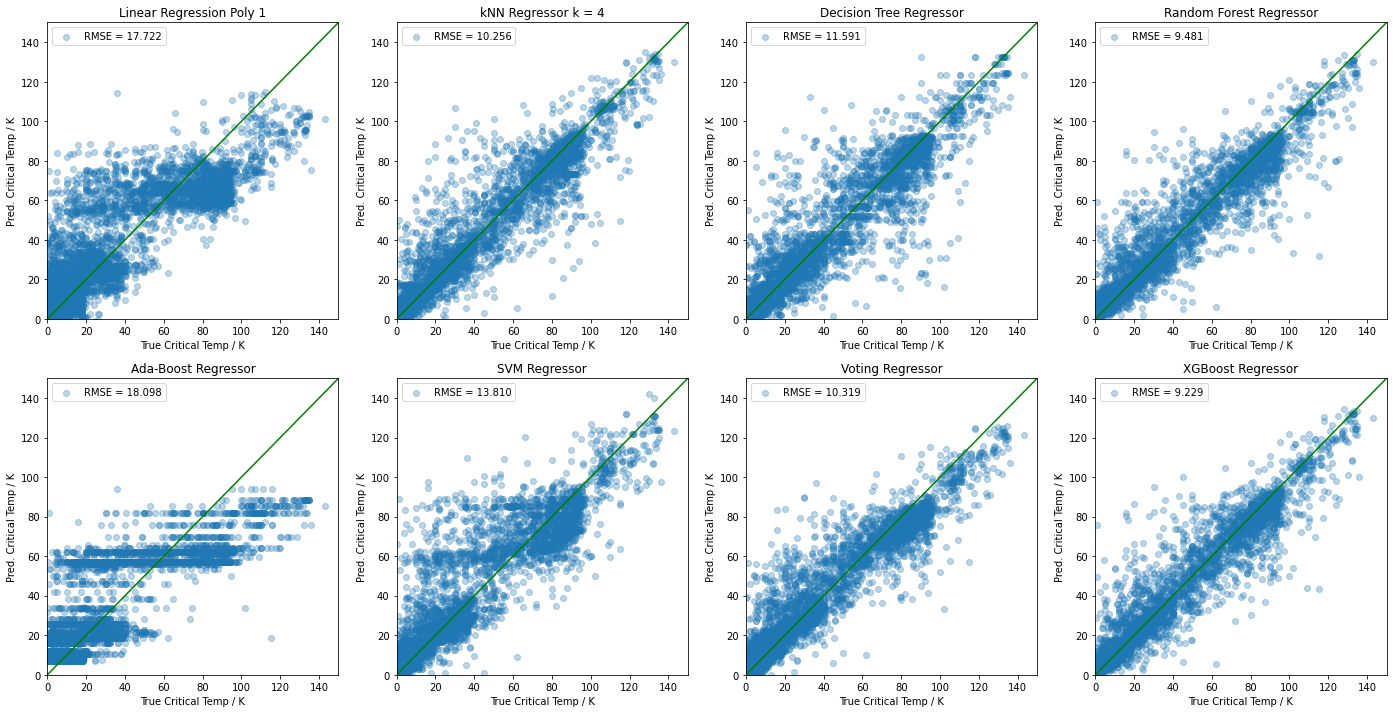

In [70]:
titles = [f"Linear Regression Poly {grd}", f"kNN Regressor k = {kmin}", "Decision Tree Regressor", "Random Forest Regressor", "Ada-Boost Regressor", "SVM Regressor", "Voting Regressor", "XGBoost Regressor"]
pred = [lin_pred, knn_pred, tr_pred, rf_pred, ada_pred, svm_pred, vot_pred, xgb_pred]
rmse = [rmse_lin, rmse_knn, rmse_tr, rmse_rf, rmse_ada, rmse_svm, rmse_vot, rmse_xgb]
#fig = plt.figure(figsize=(15,24))
fig = plt.figure(figsize=(24,12))
for i in range(1, 9):
#    ax = fig.add_subplot(4, 2, i)
    ax = fig.add_subplot(2, 4, i)
    ax.set_title(titles[i-1])
    ax.scatter(y_test, pred[i-1], alpha=0.3, label=f"RMSE = {rmse[i-1]:.3f}")
    ax.plot([0,150], [0,150], color='green')
    ax.set_xlim(0,150)
    ax.set_ylim(0,150)
    ax.set_xlabel("True Critical Temp / K")
    ax.set_ylabel("Pred. Critical Temp / K")
    ax.legend()
fig.savefig('../graph/pred_cross_fulll.jpg', dpi=150)

## Comparison of RMSE performances (smaller is better)

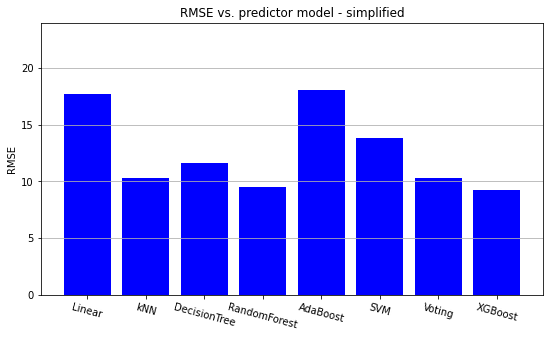

In [71]:
fig = plt.figure(figsize=(9,5))
plt.title("RMSE vs. predictor model - simplified")
names = ["Linear", "kNN", "DecisionTree", "RandomForest", "AdaBoost", "SVM", "Voting", "XGBoost"]
cl = ["blue", "blue", "blue", "blue", "blue", "blue", "blue", "blue"]
values = [rmse_lin, rmse_knn, rmse_tr, rmse_rf, rmse_ada, rmse_svm, rmse_vot, rmse_xgb]
plt.bar(names, values, color = cl)
# plt.ylim(min(values)-1, max(values)+1)
plt.ylim(0, 24)
plt.xticks(rotation=-15)
plt.ylabel("RMSE")
plt.grid(axis='y')
fig.savefig('../graph/RMSE_red.jpg', dpi=150)

## Display of feature importances (not applicable to all algorithms)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


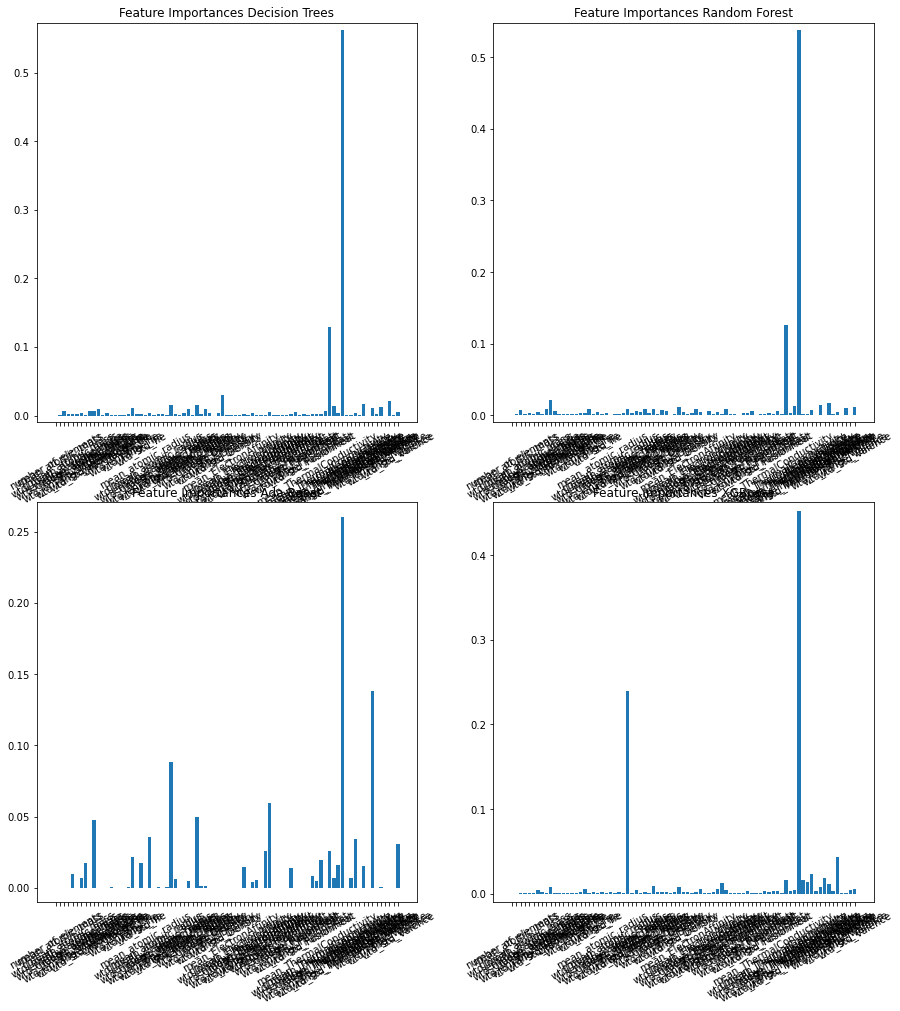

In [68]:
#linf = lin.coef_.tolist()[1:]
#titles = ["Koeffizienten der lin. Regression", "Feature Impotances des Decision Trees", "Feature Impotances des Random Forest", "Feature Impotances des Ada Boost", "Feature Impotances des XGBoost"]
#values = [linf, tr.feature_importances_, rf.feature_importances_, ada.feature_importances_, xgb.feature_importances_]
titles = ["Feature Importances Decision Trees", "Feature Importances Random Forest", "Feature Importances Ada Boost", "Feature Importances XGBoost"]
values = [tr.feature_importances_, rf.feature_importances_, ada.feature_importances_, xgb.feature_importances_]
col = x_train.columns
fig = plt.figure(figsize=(15,25))
for i in range(1, 5):
    ax = fig.add_subplot(3, 2, i)
    ax.set_title(titles[i-1])
    ax.bar(col, values[i-1])
    ax.set_xticklabels(labels=col,rotation=30)
    ax.set_ylim(min(values[i-1])-0.01, max(values[i-1])+0.01)

## Output of elapsed time

In [69]:
end = time.time()
runtime = end - start
print(f"Runtime = {runtime:.2f} s")

Runtime = 2553.40 s
